# HW2
### Fatemeh Almodaresi (ID: 117000986)
### Hamidreza Kazemi (ID: ???)


-----------------------------------------

# 1 -
The degree distribution does not fit the Erdos-Reny network model because the real data does not always act like a random model. For example in many cases the degree distribution in a real network is actually following a powerlaw distribution model with a skewed tail.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# import math
# from decimal import Decimal

In [8]:
root='/mnt/scratch1/fatemeh/courses/hw1/'

In [39]:
adj = pd.read_csv(root+'genetic_interaction_amat.csv', sep=",")

In [40]:
len(adj)

2803

In [51]:
simAdj[0][0]

0

Text(0, 0.5, 'frequency')

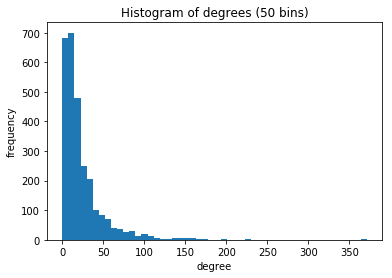

In [58]:
degrees = adj.sum(1)
plt.hist(degrees, bins=50)
plt.title("Histogram of degrees (50 bins)")
plt.xlabel("degree")
plt.ylabel("frequency")
# degreeDist = degrees.value_counts()
# degreeDist = degreeDist.sort_index()
# degreeDist = degreeDist/len(degrees)
# ax = plt.gca()
# plt.scatter(degreeDist.index+1, degreeDist.values)
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.xlabel("degree (log)")
# plt.ylabel("frequency (log)")
# plt.title("degree distribution (log-log)")

## Network Initialization

In [97]:
def initialize(m0 = 5, k = 5, m = 30, n = len(adj)):
    simAdj = [[0 for i in range(n)] for j in range(n)]
    # Target nodes for new edges 
    nodes=list(range(m0)) 

    repeated_nodes=[] 
    edgeCntr = 0
    # pure random initialization of the graph with m0 nodes and k edges
    # first guarantee that each node has at least one edge connected to it
    for i in range(m0):
        src = i
        while 1:
            dest = random.sample(range(m0), 1)[0]
            if src > dest:
                src,dest=dest,src
            if src != dest and simAdj[src][dest] == 0:
                break
        simAdj[src][dest] = 1
        edgeCntr+=1
        repeated_nodes += [src]
        repeated_nodes += [dest]

    print('At this point we guarantee that each node has at least one edge connected to it')
    # then create the rest of the random edges for the inital graph    
    while edgeCntr < k:
        randEdge = random.sample(range(m0*m0), k-edgeCntr)
        for e in randEdge:
            i = int(e/m0)
            j = int(e%m0)
            if i > j:
                i,j=j,i
            if i != j and simAdj[i][j] == 0:
                simAdj[i][j] = 1
                repeated_nodes += [i]
                repeated_nodes += [j]
                edgeCntr += 1
    print('Random graph initialization done')
    return simAdj, repeated_nodes

## 1 - Barabasi-Albert Model

In [98]:
# List of existing nodes, with nodes repeated once for each adjacent edge 
# Start adding the other n-m nodes. The first node is m. 
n = len(adj)
m0 = 100
k = 200
m = 15
simAdj, repeated_nodes = initialize(m0, k, m)
newNode=m0
while newNode<n: 
    cntr = 0
    while cntr < m:
        dests = random.sample(repeated_nodes, m)
#         print(dests)
        for d in dests:
            src = newNode
            dest = d
            if src > dest:
                src,dest=dest,src
            if src != dest and simAdj[src][dest] != 1:
                simAdj[src][dest] = 1
                repeated_nodes += [src]
                repeated_nodes += [dest]
                cntr+=1
    newNode+=1
    print(newNode, end="\r")

At this point we guarantee that each node has at least one edge connected to it
Random graph initialization done


## 2 - degree distribution

In [99]:
for i in range(len(simAdj)):
    for j in range(i+1, len(simAdj)):
        simAdj[j][i] = simAdj[i][j]
simAdj_df = pd.DataFrame.from_records(simAdj)

Text(0, 0.5, 'frequency')

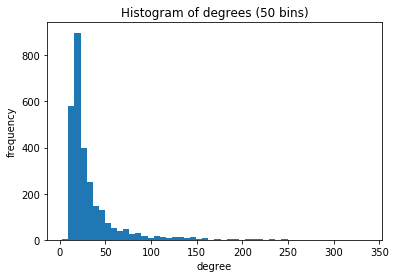

In [100]:
degrees = simAdj_df.sum(1)
plt.hist(degrees, bins=50)
plt.title("Histogram of degrees (50 bins)")
plt.xlabel("degree")
plt.ylabel("frequency")
# degreeDist = degrees.value_counts()
# degreeDist = degreeDist.sort_index()
# degreeDist = degreeDist/len(degrees)
# ax = plt.gca()
# plt.scatter(degreeDist.index+1, degreeDist.values)
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.xlabel("degree (log)")
# plt.ylabel("frequency (log)")
# plt.title("degree distribution (log-log)")

## 3 - duplication model

In [105]:
p = 0.7
r = 1
n = len(adj)
m0 = 10
k = 20
simAdj, repeated_nodes = initialize(m0, k)
newNode=m0
while newNode<n: 
    cntr = 0
    node = random.sample(range(newNode-1), 1)[0]

#         print(dests)
    for i in range(n):
        if simAdj[node][i] == 1 and np.random.rand() > p: # with probability p remove the edge (or don't add it!)
            simAdj[newNode][i] = 1
        if simAdj[i][node] == 1 and np.random.rand() > p:
            simAdj[i][newNode] = 1
    for i in range(node+1, n):
        if simAdj[node][i] == 0:
            if np.random.rand() < r/newNode:
                simAdj[node][i] = 1
    for i in range(node-1):
        if simAdj[i][node] == 0:
            if np.random.rand() < r/newNode:
                simAdj[i][node] = 1
    newNode+=1
    print(newNode, end="\r")

At this point we guarantee that each node has at least one edge connected to it
Random graph initialization done


Text(0, 0.5, 'frequency')

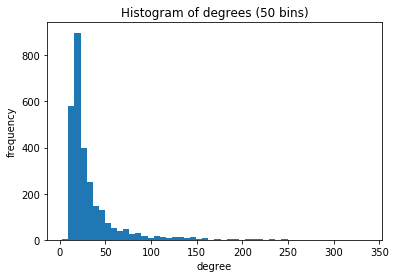

In [102]:
degrees = simAdj_df.sum(1)
plt.hist(degrees, bins=50)
plt.title("Histogram of degrees (50 bins)")
plt.xlabel("degree")
plt.ylabel("frequency")
# degreeDist = degrees.value_counts()
# degreeDist = degreeDist.sort_index()
# degreeDist = degreeDist/len(degrees)
# ax = plt.gca()
# plt.scatter(degreeDist.index+1, degreeDist.values)
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.xlabel("degree (log)")
# plt.ylabel("frequency (log)")
# plt.title("degree distribution (log-log)")